In [ ]:
pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=99943761841f195fd1087d4c88a4bcf0c962faf0a42511b0b901d63616e8de76
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/Shared drives/ECE765 Group Project')
%cd /content/gdrive/Shared drives/ECE765 Group Project

/content/gdrive/Shared drives/ECE765 Group Project


In [ ]:
from torch.utils.data import Dataset, DataLoader
import import_ipynb
import DataPrep_CNN
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import tensorflow as tf

importing Jupyter notebook from DataPrep_CNN.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Build Training Dataset

class TrainingDataset(Dataset):
    def __init__(self):
      self.preimages = read_training_data()
      self.images = normalized_images(self.preimages)
      self.labels = np.array([0] * 4739 + [1] * 4738)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      img = self.images[idx]
      label = self.labels[idx]
      return img, label

def trainDataset():
  train_dataset = TrainingDataset()
  return train_dataset

#Build Validation Dataset

class ValDataset(Dataset):
    def __init__(self):
      self.preimages = read_val_data()
      self.images = normalized_images(self.preimages)
      self.labels = np.array([0] * 500 + [1] * 500)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      img = self.images[idx]
      label = self.labels[idx]
      return img, label

def valDataset():
  val_dataset = ValDataset()
  return val_dataset

In [ ]:
trainImages = torch.load('/content/gdrive/Shared drives/ECE765 Group Project/trainImages_vae.pt')
valImages = torch.load('/content/gdrive/Shared drives/ECE765 Group Project/valImages_vae.pt')
x = trainImages.images.numpy()
x_dataset = x[0:4738]
x_dataset = np.moveaxis(x_dataset,1,3)
x_dataset.shape

(4738, 128, 128, 3)

In [ ]:
# load pca model
pca_model_file = '/content/gdrive/Shared drives/ECE765 Group Project/pca128'
pca = joblib.load(pca_model_file)
n_components = pca.n_components_

In [ ]:
# Need to re-include loss functions so model knows how to load them
def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logx_loss(x, x_decoded_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(_x_decoded_var + var_epsilon)
            + 0.5 * K.square(x - x_decoded_mean) / (_x_decoded_var + var_epsilon))
    loss = K.sum(loss, axis=-1)
    return K.mean(loss)

def vae_loss(x, x_decoded_mean):
    return logx_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

vae_path = "/content/gdrive/Shared drives/ECE765 Group Project/vae_model128.hdf5"
vae = keras.models.load_model(vae_path, custom_objects={'vae_loss': vae_loss}, compile=False)

In [ ]:
# reconstruct image
digit_size = 128
img_rows, img_cols, img_chns = 128, 128, 3
batch_size=64
image = trainImages.images[10]
image = np.moveaxis(image.numpy(),0,2)
X_sample = np.stack([image] * batch_size)
batch = pca.transform(X_sample.reshape(batch_size, -1) / 255.)
x_decoded = vae.predict(batch, batch_size=batch_size)
# Convert back to RGB format
x_recon = np.clip(pca.inverse_transform(x_decoded), 0.0, .999)
x_recon *= 255.
analogue = x_recon.reshape(batch_size, digit_size, digit_size, img_chns)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


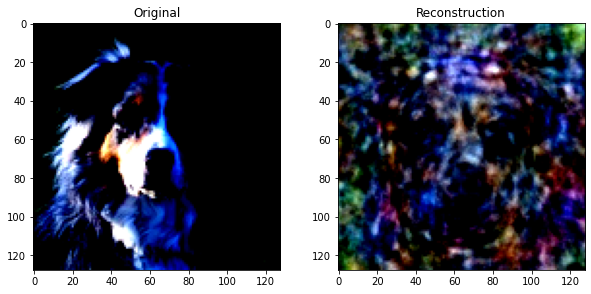

In [ ]:
# display image and its reconstruction
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Original')
plt.imshow(np.squeeze(image))
ax2 = fig.add_subplot(222)
ax2.title.set_text('Reconstruction')
plt.imshow(np.squeeze(analogue[0]))

In [ ]:
# find image with lowest reconstruction loss
losses = []
count = 0
for image in valImages.images:
  image = image.numpy()
  image = np.moveaxis(image,0,2)
  X_sample = np.stack([image] * batch_size)
  batch = pca.transform(X_sample.reshape(batch_size, -1) / 255.)
  x_decoded = vae.predict(batch, batch_size=batch_size)
  # Convert back to RGB format
  x_recon = np.clip(pca.inverse_transform(x_decoded), 0.0, .999)
  x_recon *= 255.
  analogue = x_recon.reshape(batch_size, digit_size, digit_size, img_chns)

  loss = (tf.reduce_mean(keras.losses.mean_squared_error(image, analogue[0])) * 3072).numpy()
  losses.append(loss)
  count += 1 

  if count % 10 == 0:
    print(count)

Text(0.5, 0, 'Image')

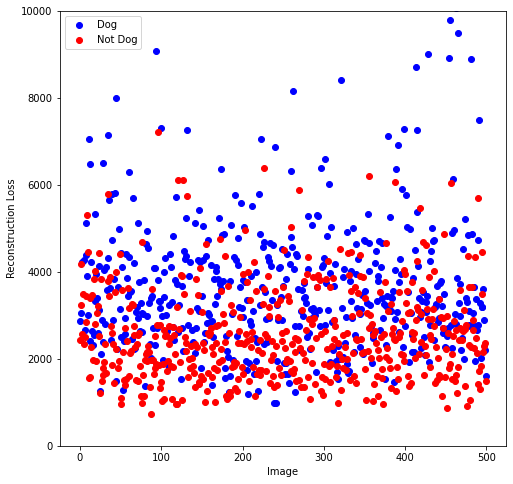

In [ ]:
# plot classifcation results

fig1 = plt.figure(figsize=(8,8))
ax = plt.scatter(y = losses[0:500], x = range(0,500), color='b', label = 'Dog')  #dogs
ax1 = plt.scatter(y = losses[500:], x = range(0,500), color='r', label = 'Not Dog')  #not dogs
plt.axhline(y=200, color='lime', linestyle='--', linewidth=6, label="Decision Boundary")
plt.legend()
plt.ylabel('Reconstruction Loss')
plt.xlabel('Image')